In [111]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import imageio
import os

# 1. Washboard Potential

"Washboard potentials" are 1-D potential energy functions with many local minima. They arise in the theory of supercondicting Josephson junctions, the motion of defects in crystals, and many other applications. Consider the following washbarod potential

$$V(r) = A_1 \cos(r) + A_2 \cos(2r) - F r$$

with $A_1 = 5$, $A_2 = 1$, and $F$ initially set to 1.5.

## Part A

Plot $V(r)$ over $(-10,10)$. Numerically find the local maximum of $V$ near zero and the local minimum of $V$ to the left (negative side) of zero. What is the potential energy barrier for moving from one well to the next in this potential?

In [89]:
def V(r,F):
    A_1 = 5
    A_2 = 1
    return A_1 * np.cos(r) + A_2 * np.cos(2*r) - F * r

def diff(func,r,F):
    # Use the complex-step method
    h = 1e-30
    return np.imag(func(r + 1j*h,F))/h

def find_extremum(func,F,rLeft,rRight):
    tol = 1e-6
    for i in range(1,500):
        rMid = (rLeft + rRight)/2
        leftPoint = diff(func,rLeft,F)
        rightPoint = diff(func,rRight,F)
        midPoint = diff(func,rMid,F)
        
        if np.sign(midPoint) == np.sign(leftPoint):
            rLeft = rMid
        else:
            rRight = rMid
            
         
        if np.abs(rLeft - rRight) < tol:
            break
        
    return rMid

Text(0, 0.5, 'V')

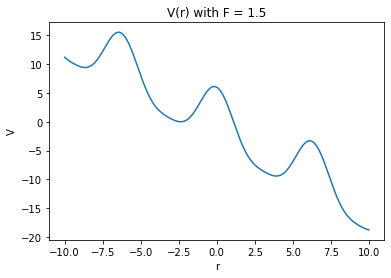

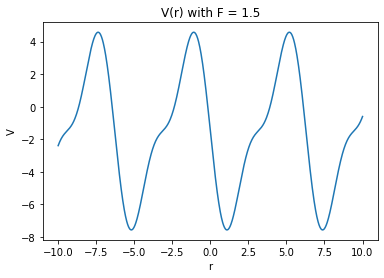

In [80]:
r = np.linspace(-10,10,1000)

plt.figure()
plt.plot(r,V(r,1.5))
plt.title("V(r) with F = 1.5")
plt.xlabel("r")
plt.ylabel("V")

plt.figure()
plt.plot(r,diff(V,r,1.5))
plt.title("V(r) with F = 1.5")
plt.xlabel("r")
plt.ylabel("V")

The potential energy barrier is  6.127109544004874  Volts


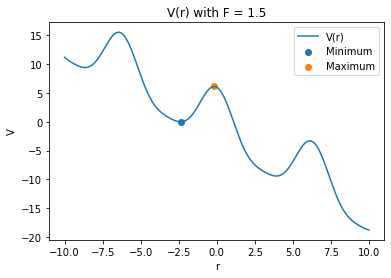

In [143]:
# Searching for the minimum and maximum
r_min = find_extremum(V,1.5,-5,-1)
r_max = find_extremum(V,1.5,-1,1)

plt.figure()
plt.plot(r,V(r,1.5),label = "V(r)")
#plt.plot(r,diff(V,r,1.5), label = "diff(V(r))")
plt.scatter(r_min,V(r_min,1.5), label = "Minimum")
plt.scatter(r_max,V(r_max,1.5), label = "Maximum")
plt.title("V(r) with F = 1.5")
plt.xlabel("r")
plt.ylabel("V")
plt.legend()

print("The potential energy barrier is ",V(r_max,1.5) - V(r_min,1.5)," Volts")

## Part B

Usually finding the minimum is only a first step. Often, one wants to explore how the minimum moves and disappears. Increase the external tilting field $F$, roughly estimate the field $F_c$ at which the barrier disappears. Also, estimate the location $r_c$ at this field where the potential minimum and maximum merge. (This is an example of a saddle-node bifurication.) Give the criterion on the first derivative and the second derivative of $V(r)$ at $F_c$ and $r_c$. Using these two equations, numerically use a root-finding routine to locate the saddle-node bifurication $F_c$ and $r_c$.

In [145]:
r_max

-0.1685190200805664

In [149]:
filenames = []

r_min = -2.366
r_max = -0.169

r = np.linspace(-10,10,1000)

color_min = "blue"
color_max = "orange"

for F in np.linspace(1.5,8,150):
    
    if abs(V(r_min,F) - V(r_max,F)) < 0.1:
        print("Saturation at r = ",r_min," and F = ",F)
        color_min = "red"
        color_max = "red"
    
    r_min = find_extremum(V,F,r_min - 0.1,r_min + 0.1)
    r_max = find_extremum(V,F,r_max - 0.1,r_max + 0.1)
    
    fig = plt.figure()
    plt.plot(r,V(r,F),label = "V(r)")
    plt.scatter(r_min,V(r_min,F), label = "Minimum",color = color_min)
    plt.scatter(r_max,V(r_max,F), label = "Maximum",color = color_max)
    plt.title("V(r)")
    plt.xlabel("r")
    plt.ylabel("V")
    #plt.ylim(-20,20)
    plt.legend()
    plt.draw()
    
    # create file name and append it to a list
    filename = f'{F}.png'
    filenames.append(filename)
    
    # save frame
    fig.savefig(filename)
    plt.close()

# build gif form the individual images
with imageio.get_writer('example.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove auxillary files
for filename in filenames:
    os.remove(filename)

Saturation at r =  -1.3507259521484294  and F =  5.775167785234899
Saturation at r =  -1.3329410705566325  and F =  5.818791946308725
Saturation at r =  -1.313941589355461  and F =  5.8624161073825505
Saturation at r =  -1.2933887634277266  and F =  5.906040268456376
Saturation at r =  -1.2707561645507737  and F =  5.949664429530201
Saturation at r =  -1.245141998291008  and F =  5.993288590604027
Saturation at r =  -1.2147197875976485  and F =  6.0369127516778525
Saturation at r =  -1.1744129333496016  and F =  6.080536912751678
Saturation at r =  -1.0744136962890547  and F =  6.124161073825503
Saturation at r =  -0.9744144592285078  and F =  6.167785234899329


<img src="example.gif" width="500" align="center">

The estimated saturation is at $r_c \approx -1.35$ and $F_c \approx 5.78$.

To solve for this in a more robust manner, we use the derivatives. At a saddle point, the first and second derivatives with respect to $r$ must be zero:

$$V'(r) = -A_1 \sin(r) - 2 A_2 \sin(2r) - F = 0$$

$$V''(r) = -A_1 \cos(r) - 4 A_2 \cos(2r) = 0$$

We can solve this system of equations by using `scipy.optimize.fsolve`:

In [156]:
A_1 = 5
A_2 = 1

def equations(vars):
    r,F = vars
    return [-A_1*np.sin(r) - 2*A_2*np.sin(2*r) - F, -A_1*np.cos(r) - 4*A_2*np.cos(2*r)]

# A root-finding function
rc,Fc = optimize.fsolve(equations, [-1.35, 5.78])

print("rc = ", rc,", Fc = ",Fc)

rc =  -1.092145208249667 , Fc =  6.073367741558359


We can see here that my estimate was close to the actual solution.

# 2. Sloppy Minimization

Optimization problems that arise in data fitting are often extremely ill-conditioned (a phenomenon sometimes called "sloppiness"). A classically ill-conditioned fitting problem involves a sum of oexponentials to data. Consider the function

$$y(t) = \frac{1}{N} \sum_{n = 0}^{N-1} \lambda_n e^{\lambda_n t}$$

Now suppose you don't know the parameters $\lambda_n$. Can you reconstruct them by fitting to experimental data $y_0(t)$?

Consider the case of $N = 2$. Suppose the actual parameters are $\lambda_0 = 2$ and $\lambda_1 = 3$ (so the experiment has data $y_0(t) = e^{-2 t} + \frac{3}{2}e^{-3 t}$) and we try to monomize the least squared error in the fits C:

$$C(\lambda) = \int_0^\infty (y(t) - y_0(t))^2 dt$$

You can check thaht this integral evaluates to

$$C(\lambda) = -\frac{51}{40} + \frac{\lambda_0}{8} - \frac{\lambda_0}{2 + \lambda_0} - \frac{3 \lambda_0}{2(3 + \lambda_0)} + \frac{\lambda_1}{8} + \frac{2}{2 + \lambda_1} + \frac{9}{2(3 + \lambda_1)} + \frac{\lambda_0 \lambda_1}{2(\lambda_0 + \lambda_1)}$$

## Part A

Draw a contour plot of $C$ in the square $1.5 < \lambda_n < 3.5$ with enough contours (perhaps non-equally spaced) so that the two minima can be distinguished. (You'll also need a fiarly fine grid of points.) You should see that inferring the two rate constants separately is challenging. This is because the two exponentials have similar shapes, so increasing one decay rate and decreasing the other can almost perfectly compensate for one another.

## Part B

Assume the two parameters are equal $(\lambda = \lambda_0 = \lambda_1)$, minimize the cost to find the optimal choice for $\lambda$. Where is this point on the contour plot? Plot $y_0(t)$ and $y(t)$ with thtis single-exponent best fit on the same graph, over $0 < t < 2$. Do you agree that it would be difficult to distinguish these two fits?

## Part C

This problem becomes much more severe in high dimensions. The banana-shaped ellipses on your contour plot can become needle-like, with aspect ratios of more than a thousand to one (about the same as a human hair). Foollowing these thin paths down to the true minima can be a challenge for multi-dimensional minimization programs. Find a method for storing and plotting the locations visited by your minimization routine (ie. values $(\lambda_0,\lambda_1)$ at which it evaluates $C$ while searching for the minimum). Starting from $\lambda_0 = 1, \lambda_1 = 4$, minimize the cost using as many methods as is convenient within your programming environment, eg. Nelder-Mead, Powell, Newton, Quasi-Newton, conjugate gradient, Levenberge-Margquardt (aka nonlinear least squares). Try to use at least one that does not demand erivatives of the function. Plot the evaluation pooints on top of the contour plot of the cost for each method. Compare the number of function evaluations needed for each method.

# 3. Convex Functions

Consider a vector in $x \in R^n$. The I-p norms are a family of vector norms parameterized by p:

$$||x||_p = \left( \sum_{k = 0}^{n-1} |x_p|^p \right)^{\frac{1}{p}}$$

## Part A

Show that $||x||_p$ is a convex function for any $p \geq 1$. Hint, you may find the Minkowski inequality helpful:

$$||x + y||_p \leq ||x||_p + ||y||_p$$

## Part B

The I-p norm defines a valid vector norm for any $p \geq 1$. for $p < 1$, it no longer defines a norm, but sometimes it is useful to think about hte function for $p < 1$. Show that the "I-0" norm counts the numebr of non-zero components of the vector. Show that the "I-0" norm is not convex.

# 4. Convex Optimization

## Part A

In your environment, fin a convex optimization DXL. What are soome of hte algorithms that are available?

## Part B

Solve the following optimization problem:

$$\textrm{min}_x ||J(x - x_0)||_2^2 + \lambda||x||_1$$

$$x_i \geq 0$$

for the $J$ and $x_0$ in the attached file (get zip file online).

$||\cdot||_p$ denotes the p-norm and $\lambda = 0, 10^{-8},10^{-4},10^{-2},1$ is a Lagrange multiplier. For each value of $\lambda$, repor the value of your optimized objective function and the number of components of $x$ that are zeros (ie. the number of constraints that are saturated at your solution vector)